# Large deformations for points.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import nibabel as nib
import os
import summerschool as ss
import scipy.interpolate as spi
from scipy.optimize import minimize
from functools import partial

## Invertable mappings have nonzero determinant of Jacobian

## The failure of smooth splines
Regardless of how smooth a Green's kernel is chosen to be, the simple transformation defined by one landmark point at $x_0$, $x\mapsto x + a K(x - x_0)$, will become not invertable for some value of $a \in \mathbb{R}^d$ (for $d=1,2$ or 3 as appropriate).

To see this, consider the 1d problem with a Gaussian kernel, and look at the determinant of Jacobian of the mapping, which is just the derivative in this case.

\begin{align*}
\frac{d}{dx} x + a \exp( -|x - x_0|^2/2\sigma^2) &= 1 - a\sigma^2 (x - x_0) \exp( -|x - x_0|^2/2\sigma^2)
\end{align*}

Consider the point $x = x_0 + 1$.  The expression becomes $1 - a\sigma^2 \exp(-1/2\sigma^2)$.  This is zero for $a = \frac{1}{\sigma^2 \exp(-1/2\sigma^2)}$, and negative for any larger $a$.

Regardless of how smooth $K$ is, we will run into this problem for large deformations.

Notice however that for small $a$, the determinant of Jacobian becomes arbitrarily close to 1.  Small enough deformations are always invertable with smooth kernels.

<IPython.core.display.Javascript object>


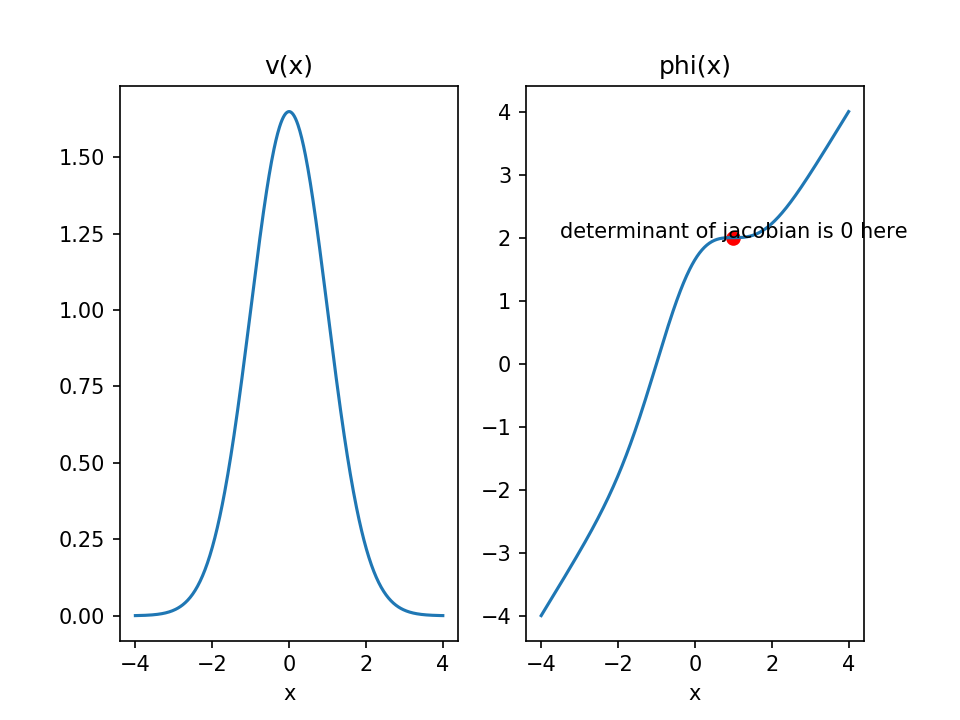

In [2]:
# example
sigma = 1.0
x = np.linspace(-4,4,500)
x0 = 0.0

a = 1.0/(sigma**2 * np.exp(-1.0/2.0/sigma**2))
v = a * np.exp( -(x - x0)**2/2.0/sigma**2 )

f,ax = plt.subplots(1,2)
ax[0].plot(x,v)
ax[0].set_xlabel('x')
ax[0].set_title('v(x)')
ax[1].plot(x,x+v)
ax[1].set_xlabel('x')
ax[1].set_title('phi(x)')
ax[1].scatter(1,1 + a * np.exp(-(1)**2/2.0/sigma**2),color='r')
ax[1].text(1,1 + a * np.exp(-(1)**2/2.0/sigma**2), 'determinant of jacobian is 0 here', horizontalalignment='center')
plt.show()

In [3]:
# Define all functions I used in this tutorial

# use a Gaussian kernel
k = lambda x, y: np.exp(-np.sum((x-y)**2)/(2.0*sig**2))

def k_d1(x,y):
    v = -k(x,y)*(x-y)/sig**2
    return v
    

# compute Kernal Matrix
def K_mat(x,y):
    K = np.empty((len(x[0]),len(y[0])))
#     print(K.shape)
    for i in range(len(x[1])):
        for j in range(len(y[1])):
            K[i,j] = k(x[:,i],y[:,j])
    return K
# print(K_mat(X,Y))

def K_d1_mat(x,y,n):
    d,N = x.shape
    Kd = np.zeros((d,N,N))
#     print(K.shape)
    for i in range(N):
        Kd[:,i,n] = k_d1(x[:,i],y[:,n])
    for j in range(N):   
        Kd[:,n,j] = k_d1(x[:,n],y[:,j])
    return Kd

# End points cost function sum of square error (matching cost function)
def G(x,y):
    return np.sum((x-y)**2)
# print(G(X,X))


# Compute flows
def Compute_phi_forward(x0,a):
    d,N,T = a.shape
    Z = np.zeros((d,N,T+1))
    Z[:,:,0] = x0
    for t in range(T):
        Kzz = K_mat(Z[:,:,t],Z[:,:,t])
        for i in range(d):
            Z[i,:,t+1] = Z[i,:,t]+np.dot(Kzz,a[i,:,t])/T
    return Z

# p(T-1) = -dG(z(T))

def Compute_final_costate(z_end,Y,c):
    P_final = -2.0*c*(Y-z_end)
    return P_final

def Compute_phi_backward(P_final,Z,a):
    d,N,T = a.shape
    P_inv = np.zeros((d,N,T))
    P_inv[:,:,T-1] = P_final
    
    for t in range(T-1,0,-1):
        for n in range(N):
            dKzz = K_d1_mat(Z[:,:,t],Z[:,:,t],n)
            for i in range(d):
                P_inv[i,n,t-1] = P_inv[i,n,t]+np.dot(np.dot(dKzz[i,:,:],a[i,:,t]),(P_inv[i,:,t]-a[i,:,t]/2))/T # I need to modify this approximation
    
    return P_inv


def Compute_dF_a(a,P_inv,Z):
    d,N,T = a.shape
    da = np.zeros((d,N,T))
    
    for t in range(T):
        Kzz = K_mat(Z[:,:,t],Z[:,:,t])
        for i in range(d):
            da[i,:,t] = np.dot(Kzz,(P_inv[i,:,t]-a[i,:,t]))/T
    return da


## Combining small deformations under composition works
Because small deformations will be 

Let's see two 2-D LDDMM landmark examples:

(a) a set of landmarks in a circle are mapping to an ellipse.

(b) a set of landmarks in a circle are mapping to an ellipse, except for the first lankmark is mapped to the (1,2). This case exhibites singularities and ambiguities. 


<IPython.core.display.Javascript object>


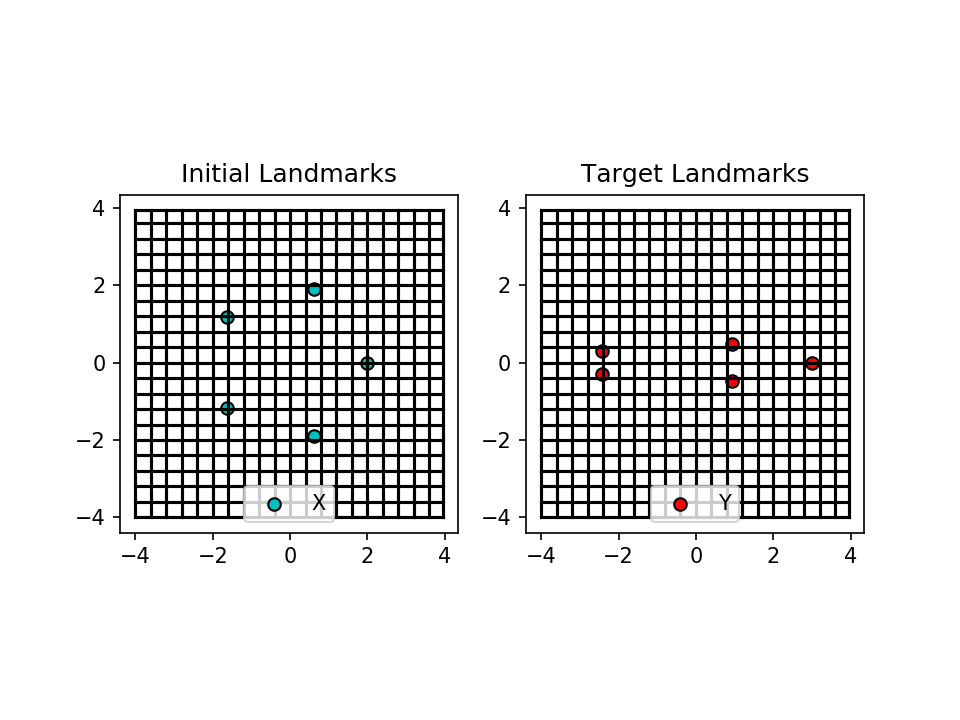

In [4]:
N = 5
n = np.arange(0,N,1)
# Example (a)
# X = np.array([np.cos(2*n*np.pi/N),np.sin(2*n*np.pi/N)])
# Y = np.array([-1+2*n/N,-1+2*n/N])

# Example (b)
X = np.array([2*np.cos(2*n*np.pi/N),2*np.sin(2*n*np.pi/N)])
Y = np.array([3*np.cos(2*n*np.pi/N),0.5*np.sin(2*n*np.pi/N)])
# print(X)
# print(Y)

f,ax = plt.subplots(1,2)
dx = 0.05
stride = 8
x0 = np.arange(-4,4,dx)
x1 = np.arange(-4,4,dx)
X0,X1 = np.meshgrid(x0,x1,indexing='ij')
ss.plot_grid(X0,X1,ax=ax[0],rstride=stride,cstride=stride)
hx = ax[0].scatter(X[0,:],X[1,:],color='c',edgecolor='k')
ax[0].set_aspect('equal')
ax[0].legend([hx],['X'])
ax[0].set_title('Initial Landmarks')

ss.plot_grid(X0,X1,ax=ax[1],rstride=stride,cstride=stride)
hy = ax[1].scatter(Y[0,:],Y[1,:],color='r',edgecolor='k')
ax[1].set_aspect('equal')
ax[1].legend([hy],['Y'])
ax[1].set_title('Target Landmarks')
plt.show()

In [5]:
# use a Gaussian kernel
k = lambda x, y: np.exp(-np.sum((x-y)**2)/(2.0*sig**2))

def k_d1(x,y):
    v = np.exp(-np.sum((x-y)**2)/(2.0*sig**2))/(sig**2)
    return v

# use a Cauchy kernel
# k = lambda x, y: np.reciprocal((1+(np.sum((x-y)**2)/(sig**2))))

Spline method: Before we use LDDMM, let's do spline method again.

Lambda : [[ 9.63578884e-01  2.97762251e-01 -7.79551693e-01 -7.79551693e-01
   2.97762251e-01]
 [ 6.93889390e-17 -1.37462697e+00 -8.49566187e-01  8.49566187e-01
   1.37462697e+00]]


<IPython.core.display.Javascript object>


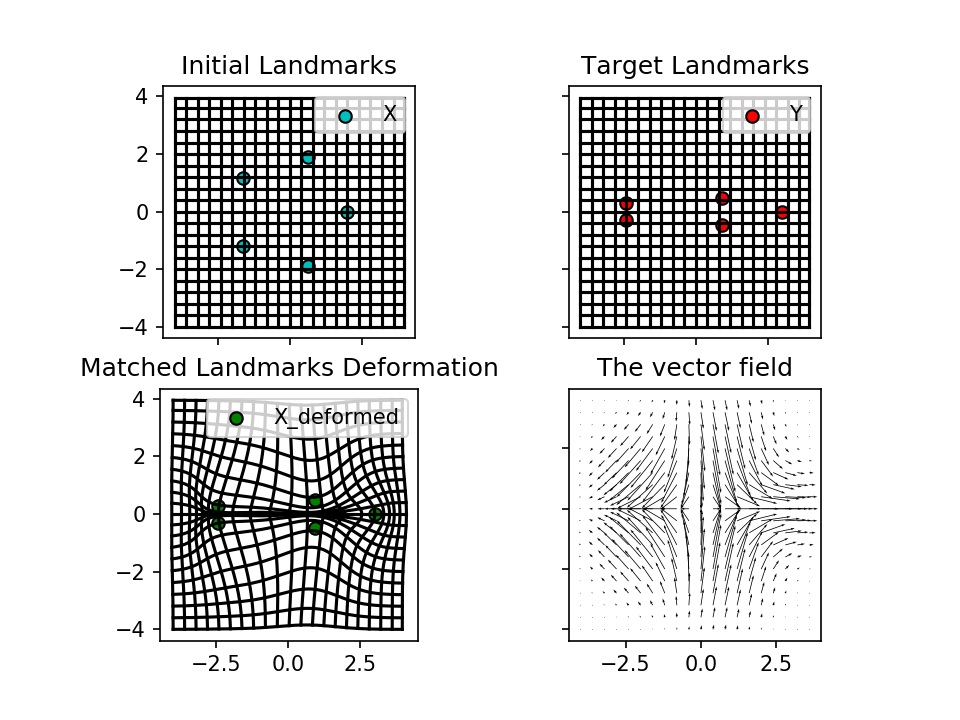

In [6]:
# N: number of landmarks
N = X.shape[1]
sig = 1.0

# Compute a kernel matrix
K = np.empty((N,N))
for i in range(N):
    for j in range(N):
        K[i,j] = k(X[:,i],X[:,j])
Lambda = np.linalg.solve(K,(Y-X).transpose()).transpose()
print('Lambda :', Lambda)

# deformed grid
dx = 0.05
stride = 8
x0 = np.arange(-4,4,dx)
x1 = np.arange(-4,4,dx)
X0,X1 = np.meshgrid(x0,x1,indexing='ij')
phiX0 = np.array(X0)
phiX1 = np.array(X1)
for i in range(len(x0)):
    for j in range(len(x1)):
        # this point
        p = np.array([X0[i,j],X1[i,j]])
        for k_ in range(N):
            phiX0[i,j] += Lambda[0,k_]*k(p,X[:,k_])
            phiX1[i,j] += Lambda[1,k_]*k(p,X[:,k_])
# print(phiX0.shape)

# deform landmarks to target
X_deform0 = np.array(X[0])
X_deform1 = np.array(X[1])
for i in range(N):
    p = np.array([X[0,i],X[1,i]])
    for j in range(N):
        X_deform0[i] += Lambda[0,j]*k(p,X[:,j])
        X_deform1[i] += Lambda[1,j]*k(p,X[:,j])
X_deform = np.array([X_deform0, X_deform1])
# print(X_deform.shape)

f,ax = plt.subplots(2,2)
dx = 0.05
stride = 8
x0 = np.arange(-4,4,dx)
x1 = np.arange(-4,4,dx)
X0,X1 = np.meshgrid(x0,x1,indexing='ij')
ss.plot_grid(X0,X1,ax=ax[0,0],rstride=stride,cstride=stride)
hx = ax[0,0].scatter(X[0,:],X[1,:],color='c',edgecolor='k')
ax[0,0].set_aspect('equal')
ax[0,0].legend([hx],['X'],loc="upper right")
ax[0,0].set_title('Initial Landmarks')

ss.plot_grid(X0,X1,ax=ax[0,1],rstride=stride,cstride=stride)
hy = ax[0,1].scatter(Y[0,:],Y[1,:],color='r',edgecolor='k')
ax[0,1].set_aspect('equal')
ax[0,1].legend([hy],['Y'],loc="upper right")
ax[0,1].set_title('Target Landmarks')

ss.plot_grid(phiX0,phiX1,ax=ax[1,0],rstride=stride,cstride=stride)
hx_deform = ax[1,0].scatter(X_deform[0,:],X_deform[1,:],color='g',edgecolor='k')
ax[1,0].set_aspect('equal')
ax[1,0].legend([hx_deform],['X_deformed'],loc="upper right")
ax[1,0].set_title('Matched Landmarks Deformation')

ax[1,1].quiver(X0[::stride,::stride],X1[::stride,::stride],phiX0[::stride,::stride]-X0[::stride,::stride],
             phiX1[::stride,::stride]-X1[::stride,::stride],
             scale=stride)
ax[1,1].set_aspect('equal')
ax[1,1].set_title('The vector field')

# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in ax[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in ax[:, 1]], visible=False)
plt.show()

Do Landmark LDDMM for this example 

In [7]:
# different approach to compute momentum a (co-state, lagrange multiplier)


# parameters
sigma = 2e0
niter = 500
epsilon = 2.0e-2

# initialize
T = 10 # Number of steps 
d,N = X.shape
a = np.zeros((d,N,T))
c = 1.0 # weighting
# make cost function only depends on momentum a
# print('Initial momentum :')
# print(a)

for it in range(niter):
    
    # Compute forward propagation
    Z = Compute_phi_forward(X,a)
    
    # Compute the final co-state by matching to target
    P_final = Compute_final_costate(Z[:,:,T],Y,c)
    
    # Compute backward propagation
    P_inv = Compute_phi_backward(P_final,Z,a)
        
    # Compute the derivative of cost function over a
    da = Compute_dF_a(a,P_inv,Z)
    
    # Update a 
    a += -epsilon*da
    
    #
#     print('Iteration : ' + str(it))
#     print(a)

In [8]:
# Compute deformed landmarks over t
Z = Compute_phi_forward(X,a)
# print(Z)

# compute deformed grid flow over t
dx = 0.05
stride = 8
x0 = np.arange(-4,4,dx)
x1 = np.arange(-4,4,dx)
X0,X1 = np.meshgrid(x0,x1,indexing='ij')
phiX0_t = np.array(X0)
phiX1_t = np.array(X1)

for t in range(T):
    for i in range(len(x0)):
        for j in range(len(x1)):
            # this point
            p = np.array([phiX0_t[i,j],phiX1_t[i,j]])
            for k_ in range(N):
                phiX0_t[i,j] += a[0,k_,t]*k(p,Z[:,k_,t])/T
                phiX1_t[i,j] += a[1,k_,t]*k(p,Z[:,k_,t])/T

<IPython.core.display.Javascript object>


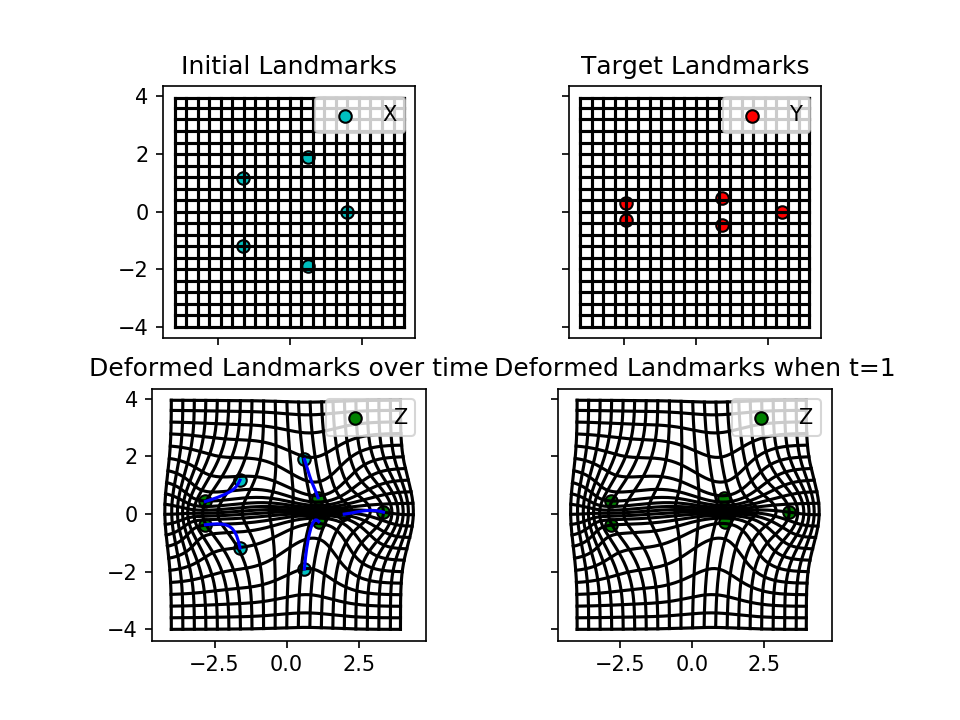

In [9]:
f,ax = plt.subplots(2,2)
# plot subject landmarks at t=0 (initial) 
ss.plot_grid(X0,X1,ax=ax[0,0],rstride=stride,cstride=stride)
hx = ax[0,0].scatter(X[0,:],X[1,:],color='c',edgecolor='k')
ax[0,0].set_aspect('equal')
ax[0,0].legend([hx],['X'],loc="upper right")
ax[0,0].set_title('Initial Landmarks')

# plot target landmarks
ss.plot_grid(X0,X1,ax=ax[0,1],rstride=stride,cstride=stride)
hy = ax[0,1].scatter(Y[0,:],Y[1,:],color='r',edgecolor='k')
ax[0,1].set_aspect('equal')
ax[0,1].legend([hy],['Y'],loc="upper right")
ax[0,1].set_title('Target Landmarks')

# plot deformed subject landmarks trajectory
ss.plot_grid(phiX0_t,phiX1_t,ax=ax[1,0],rstride=stride,cstride=stride) 
hx = ax[1,0].scatter(X[0,:],X[1,:],color='c',edgecolor='k')
for i in range(N):
    hz = ax[1,0].plot(Z[0,i,:],Z[1,i,:],color='b')
hz = ax[1,0].scatter(Z[0,:,T],Z[1,:,T],color='g',edgecolor='k')
ax[1,0].set_aspect('equal')
ax[1,0].legend([hz],['Z'],loc="upper right")
ax[1,0].set_title('Deformed Landmarks over time')

# plot deformed subjectlandmarks at t=T (final)
ss.plot_grid(phiX0_t,phiX1_t,ax=ax[1,1],rstride=stride,cstride=stride) 
hz = ax[1,1].scatter(Z[0,:,T],Z[1,:,T],color='g',edgecolor='k')
ax[1,1].set_aspect('equal')
ax[1,1].legend([hz],['Z'],loc="upper right")
ax[1,1].set_title('Deformed Landmarks when t=1')

plt.setp([a.get_xticklabels() for a in ax[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in ax[:, 1]], visible=False)
plt.show()

<IPython.core.display.Javascript object>


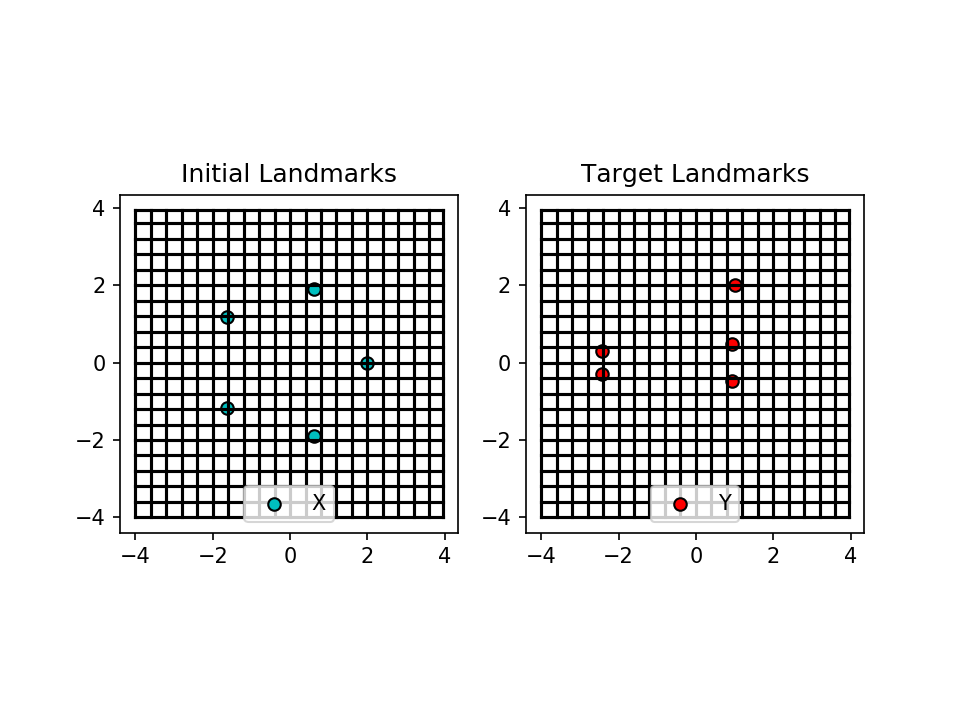

In [10]:
# Now set to different target landmarks
N = 5
n = np.arange(0,N,1)
# Example (a)
# X = np.array([np.cos(2*n*np.pi/N),np.sin(2*n*np.pi/N)])
# Y = np.array([-1+2*n/N,-1+2*n/N])

# Example (b)
X = np.array([2*np.cos(2*n*np.pi/N),2*np.sin(2*n*np.pi/N)])
Y = np.array([3*np.cos(2*n*np.pi/N),0.5*np.sin(2*n*np.pi/N)])
Y[0,0] = 1
Y[1,0] = 2

f,ax = plt.subplots(1,2)
dx = 0.05
stride = 8
x0 = np.arange(-4,4,dx)
x1 = np.arange(-4,4,dx)
X0,X1 = np.meshgrid(x0,x1,indexing='ij')
ss.plot_grid(X0,X1,ax=ax[0],rstride=stride,cstride=stride)
hx = ax[0].scatter(X[0,:],X[1,:],color='c',edgecolor='k')
ax[0].set_aspect('equal')
ax[0].legend([hx],['X'])
ax[0].set_title('Initial Landmarks')

ss.plot_grid(X0,X1,ax=ax[1],rstride=stride,cstride=stride)
hy = ax[1].scatter(Y[0,:],Y[1,:],color='r',edgecolor='k')
ax[1].set_aspect('equal')
ax[1].legend([hy],['Y'])
ax[1].set_title('Target Landmarks')
plt.show()

Do the second case by spline method:

Lambda : [[-1.05247647  0.42516968 -0.78582812 -0.78582812  0.42516968]
 [ 2.01605535 -1.50203439 -0.84328976  0.85584261  1.24721954]]


<IPython.core.display.Javascript object>


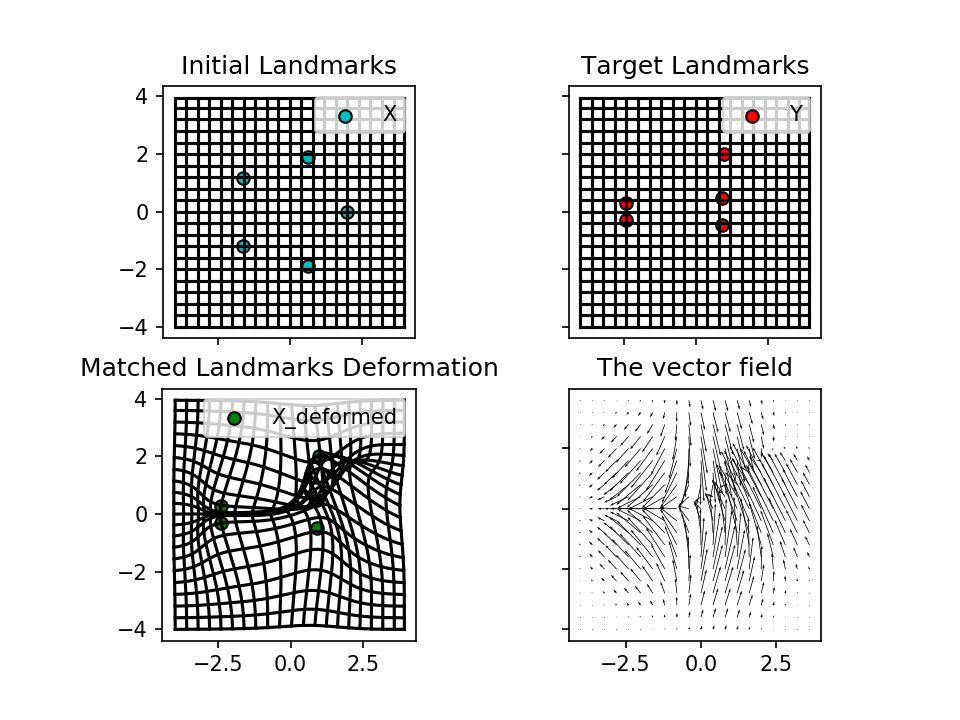

In [11]:
# N: number of landmarks
N = X.shape[1]
sig = 1.0

# Compute a kernel matrix
K = np.empty((N,N))
for i in range(N):
    for j in range(N):
        K[i,j] = k(X[:,i],X[:,j])
Lambda = np.linalg.solve(K,(Y-X).transpose()).transpose()
print('Lambda :', Lambda)

# deformed grid
dx = 0.05
stride = 8
x0 = np.arange(-4,4,dx)
x1 = np.arange(-4,4,dx)
X0,X1 = np.meshgrid(x0,x1,indexing='ij')
phiX0 = np.array(X0)
phiX1 = np.array(X1)
for i in range(len(x0)):
    for j in range(len(x1)):
        # this point
        p = np.array([X0[i,j],X1[i,j]])
        for k_ in range(N):
            phiX0[i,j] += Lambda[0,k_]*k(p,X[:,k_])
            phiX1[i,j] += Lambda[1,k_]*k(p,X[:,k_])
# print(phiX0.shape)

# deform landmarks to target
X_deform0 = np.array(X[0])
X_deform1 = np.array(X[1])
for i in range(N):
    p = np.array([X[0,i],X[1,i]])
    for j in range(N):
        X_deform0[i] += Lambda[0,j]*k(p,X[:,j])
        X_deform1[i] += Lambda[1,j]*k(p,X[:,j])
X_deform = np.array([X_deform0, X_deform1])
# print(X_deform.shape)

f,ax = plt.subplots(2,2)
dx = 0.05
stride = 8
x0 = np.arange(-4,4,dx)
x1 = np.arange(-4,4,dx)
X0,X1 = np.meshgrid(x0,x1,indexing='ij')
ss.plot_grid(X0,X1,ax=ax[0,0],rstride=stride,cstride=stride)
hx = ax[0,0].scatter(X[0,:],X[1,:],color='c',edgecolor='k')
ax[0,0].set_aspect('equal')
ax[0,0].legend([hx],['X'],loc="upper right")
ax[0,0].set_title('Initial Landmarks')

ss.plot_grid(X0,X1,ax=ax[0,1],rstride=stride,cstride=stride)
hy = ax[0,1].scatter(Y[0,:],Y[1,:],color='r',edgecolor='k')
ax[0,1].set_aspect('equal')
ax[0,1].legend([hy],['Y'],loc="upper right")
ax[0,1].set_title('Target Landmarks')

ss.plot_grid(phiX0,phiX1,ax=ax[1,0],rstride=stride,cstride=stride)
hx_deform = ax[1,0].scatter(X_deform[0,:],X_deform[1,:],color='g',edgecolor='k')
ax[1,0].set_aspect('equal')
ax[1,0].legend([hx_deform],['X_deformed'],loc="upper right")
ax[1,0].set_title('Matched Landmarks Deformation')

ax[1,1].quiver(X0[::stride,::stride],X1[::stride,::stride],phiX0[::stride,::stride]-X0[::stride,::stride],
             phiX1[::stride,::stride]-X1[::stride,::stride],
             scale=stride)
ax[1,1].set_aspect('equal')
ax[1,1].set_title('The vector field')

# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in ax[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in ax[:, 1]], visible=False)
plt.show()

LDDMM: Find optimal controls a and flows 

more comments. For res.x.. reshape....



In [12]:
# different approach to compute momentum a (co-state, lagrange multiplier)


# parameters
sigma = 2e0
niter = 500
epsilon = 2.0e-2

# initialize
T = 10 # Number of steps 
d,N = X.shape
a = np.zeros((d,N,T))
c = 1.0 # weighting
# make cost function only depends on momentum a
# print('Initial momentum :')
# print(a)

for it in range(niter):
    
    # Compute forward propagation
    Z = Compute_phi_forward(X,a)
    
    # Compute the final co-state by matching to target
    P_final = Compute_final_costate(Z[:,:,T],Y,c)
    
    # Compute backward propagation
    P_inv = Compute_phi_backward(P_final,Z,a)
        
    # Compute the derivative of cost function over a
    da = Compute_dF_a(a,P_inv,Z)
    
    # Update a 
    a += -epsilon*da
    
    #
#     print('Iteration : ' + str(it))
#     print(a)

In [13]:
# Compute deformed landmarks over t
Z = Compute_phi_forward(X,a)
# print(Z)

# compute deformed grid flow over t
dx = 0.05
stride = 8
x0 = np.arange(-4,4,dx)
x1 = np.arange(-4,4,dx)
X0,X1 = np.meshgrid(x0,x1,indexing='ij')
phiX0_t = np.array(X0)
phiX1_t = np.array(X1)

for t in range(T):
    for i in range(len(x0)):
        for j in range(len(x1)):
            # this point
            p = np.array([phiX0_t[i,j],phiX1_t[i,j]])
            for k_ in range(N):
                phiX0_t[i,j] += a[0,k_,t]*k(p,Z[:,k_,t])/T
                phiX1_t[i,j] += a[1,k_,t]*k(p,Z[:,k_,t])/T

<IPython.core.display.Javascript object>


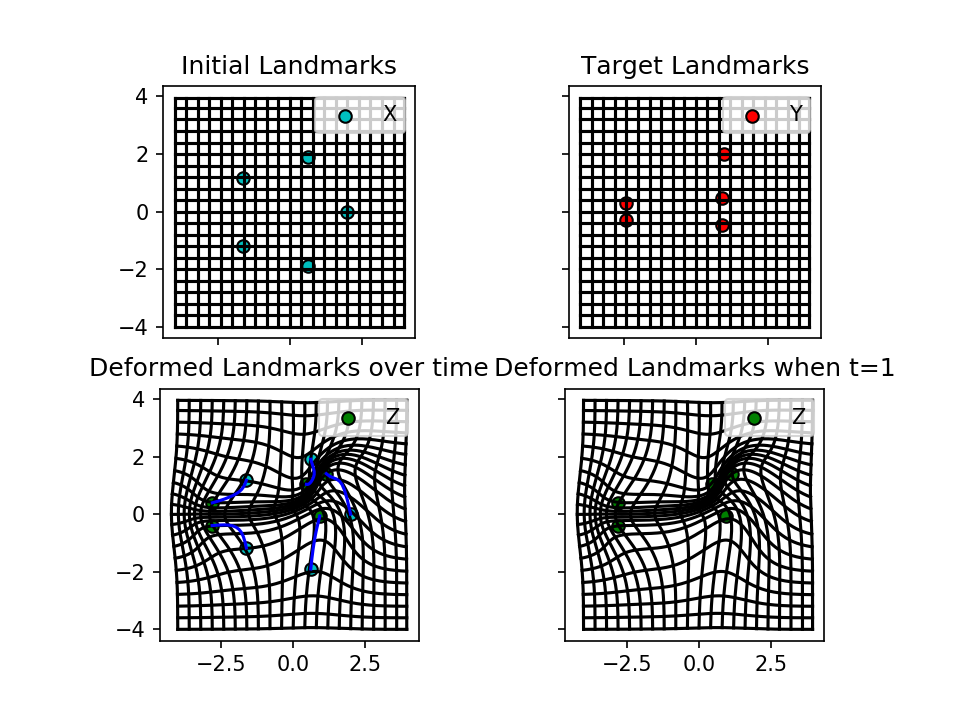

In [14]:
f,ax = plt.subplots(2,2)
# plot subject landmarks at t=0 (initial) 
ss.plot_grid(X0,X1,ax=ax[0,0],rstride=stride,cstride=stride)
hx = ax[0,0].scatter(X[0,:],X[1,:],color='c',edgecolor='k')
ax[0,0].set_aspect('equal')
ax[0,0].legend([hx],['X'],loc="upper right")
ax[0,0].set_title('Initial Landmarks')

# plot target landmarks
ss.plot_grid(X0,X1,ax=ax[0,1],rstride=stride,cstride=stride)
hy = ax[0,1].scatter(Y[0,:],Y[1,:],color='r',edgecolor='k')
ax[0,1].set_aspect('equal')
ax[0,1].legend([hy],['Y'],loc="upper right")
ax[0,1].set_title('Target Landmarks')

# plot deformed subject landmarks trajectory
ss.plot_grid(phiX0_t,phiX1_t,ax=ax[1,0],rstride=stride,cstride=stride) 
hx = ax[1,0].scatter(X[0,:],X[1,:],color='c',edgecolor='k')
for i in range(N):
    hz = ax[1,0].plot(Z[0,i,:],Z[1,i,:],color='b')
hz = ax[1,0].scatter(Z[0,:,T],Z[1,:,T],color='g',edgecolor='k')
ax[1,0].set_aspect('equal')
ax[1,0].legend([hz],['Z'],loc="upper right")
ax[1,0].set_title('Deformed Landmarks over time')

# plot deformed subjectlandmarks at t=T (final)
ss.plot_grid(phiX0_t,phiX1_t,ax=ax[1,1],rstride=stride,cstride=stride) 
hz = ax[1,1].scatter(Z[0,:,T],Z[1,:,T],color='g',edgecolor='k')
ax[1,1].set_aspect('equal')
ax[1,1].legend([hz],['Z'],loc="upper right")
ax[1,1].set_title('Deformed Landmarks when t=1')

plt.setp([a.get_xticklabels() for a in ax[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in ax[:, 1]], visible=False)
plt.show()

The following cell computes LDDMM without using derivative of F(a)